In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [3]:
import imageio
x = imageio.imread('./dataset/training/00001.png')

In [4]:
x.shape

(800, 600, 3)

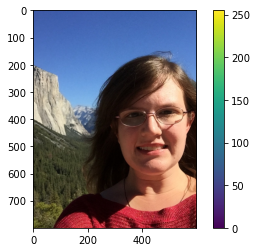

In [5]:
plt.imshow(x)
plt.colorbar()
plt.show()

In [6]:
from skimage.transform import resize
x1 = resize(x, (100, 75))

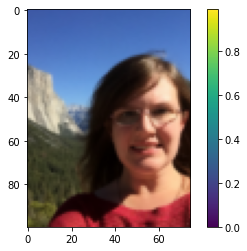

In [7]:
plt.imshow(x1)
plt.colorbar()

In [8]:
x2 = resize(x, (50,37)) #800 * 600 -> 
x2.shape

(50, 37, 3)

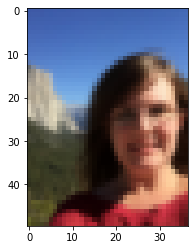

In [9]:
plt.imshow(x2)

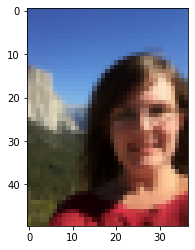

In [10]:
x3 = resize(x1,(50, 37)) # 100 75 -> 50 37
plt.imshow(x3)

In [14]:
pfcn_small = np.load('./pfcn_small.npz')

In [15]:
list(pfcn_small.keys())

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [16]:
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

In [17]:
train_big_images.shape

(1700, 100, 75, 3)

In [18]:
train_small_images = np.array([resize(img, (50, 37)) for img in train_big_images])
test_small_images = np.array([resize(img, (50, 37)) for img in test_big_images])

In [19]:
train_big_images.dtype

dtype('float64')

## 전처리

In [21]:
print(train_big_images.max(), train_big_images.min())
print(test_big_images.max(), test_big_images.min())

1.0 0.0
1.0 0.0


In [22]:
train_big_images[:5].shape 

(5, 100, 75, 3)

In [24]:
## (5, 100, 75, 3)
## (100, 5, 75, 3)
## (100, 5*75, 3)
## (100, 375, 3)
train_big_images[:5].transpose(1, 0, 2, 3).reshape((100, -1, 3)).shape

(100, 375, 3)

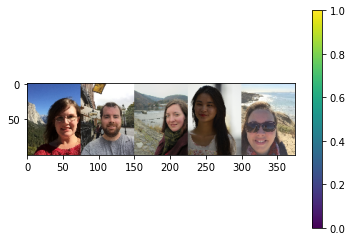

In [25]:
plt.imshow(train_big_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3)))
plt.colorbar()

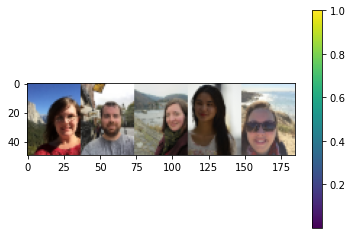

In [26]:
plt.imshow(train_small_images[:5].transpose((1, 0, 2, 3)).reshape((50, -1, 3)))
plt.colorbar()

In [27]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Dropout, Activation, concatenate

In [28]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [29]:
def unet_resoultion():
    inputs = Input((50, 37, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(0,1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(1,0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    u10 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c9)
    outputs = Conv2D(3, 1, activation="sigmoid")(u10)
    model = Model(inputs, outputs)
    return model

In [31]:
model = unet_resoultion()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 37, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 37, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 37, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [32]:
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

In [33]:
hist = model.fit(train_small_images, train_big_images, validation_data=(test_small_images, test_big_images), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 34s 273ms/step - loss: 0.2052 - accuracy: 0.4777 - val_loss: 0.2079 - val_accuracy: 0.6480
Epoch 2/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0861 - accuracy: 0.6880 - val_loss: 0.1680 - val_accuracy: 0.6949
Epoch 3/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0681 - accuracy: 0.7691 - val_loss: 0.1577 - val_accuracy: 0.7002
Epoch 4/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0642 - accuracy: 0.7749 - val_loss: 0.1485 - val_accuracy: 0.7055
Epoch 5/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0611 - accuracy: 0.7776 - val_loss: 0.1351 - val_accuracy: 0.7217
Epoch 6/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0598 - accuracy: 0.7782 - val_loss: 0.1074 - val_accuracy: 0.7393
Epoch 7/25
54/54 [==============================] - 1s 20ms/step - loss: 0.0586 - accuracy: 0.7822 - val_loss: 0.0898 - val_accuracy: 0.7548
Epoch 8/25


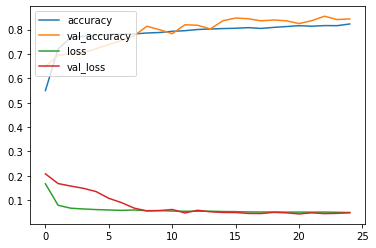

In [34]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [35]:
res = model.predict(test_small_images[1:2])
res.shape, test_small_images[:1].shape

((1, 100, 75, 3), (1, 50, 37, 3))

In [36]:
exp = resize(test_small_images[1], (100, 75))
exp.shape

(100, 75, 3)

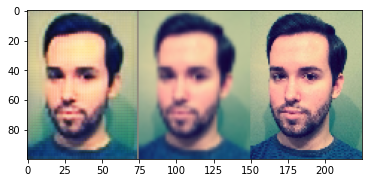

In [38]:
imgs = np.concatenate([res[0], exp, test_big_images[1]], axis=1)
plt.imshow(imgs)

In [39]:
result = model.predict(test_small_images[:3])
exps = np.array([resize(img, (100, 75))for img in test_small_images[:3]])
imgs = np.concatenate([result, exps, test_big_images[:3]], axis=2).reshape((300, -1, 3))

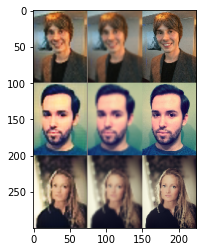

In [40]:
plt.imshow(imgs)

In [42]:
infor = model.evaluate(test_small_images, test_big_images)
print(infor)

10/10 [==============================] - 0s 6ms/step - loss: 0.0483 - accuracy: 0.8437
[0.04828980565071106, 0.8436639904975891]


In [ ]:
model.save('./lec07.h5')

In [ ]:
wig = tf.keras.models.load_model('./lec07.h5')